# Roest Lab Jupyter Notebook for Exploratory Data Analysis
This notebook is configured to the `roest-lab` virtual environment. Please ensure you have the `roest-lab` kernel activated when using this notebook.

## Required PyPI packages
- `numpy`
- `pyopenms`

## Auxiliary PyPI packages for data analysis
- `matplotlib`

In [1]:
print("Welcome to the Roest Lab Exploratory MS Jupyter Notebook!")

Welcome to the Roest Lab Exploratory MS Jupyter Notebook!


In [43]:
# Set common directories
import os

BASE_DIR = os.path.abspath(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'data')

In [9]:
# From pyOpenMS tutorial page - https://pyopenms.readthedocs.io/en/latest/first_steps.html
from pyopenms import MSExperiment, MzMLFile

exp = MSExperiment()
MzMLFile().store(os.path.join(DATA_DIR, 'testfile.mzML'), exp)


In [10]:
# Get help with Python objects in pyOpenMS
# help(MzMLFile)
# help(MSExperiment)

## File reading

In [11]:
import os
from urllib.request import urlretrieve

# Download small mzML file
github_content = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
tiny_mzml_filepath = os.path.join(DATA_DIR, "tiny.mzML")
urlretrieve(f"{github_content}/src/data/tiny.mzML", tiny_mzml_filepath)

('/Users/irahorecka/Desktop/Harddrive_Desktop/PhD/University of Toronto/Rotations/Rost Lab/roest-ms/data/tiny.mzML',
 <http.client.HTTPMessage at 0x7f9f90d9c490>)

In [12]:
from pyopenms import MSExperiment, MzMLFile

exp = MSExperiment()
# Load file
MzMLFile().load(tiny_mzml_filepath, exp)

In [13]:
# tiny_mzml_filepath is loaded onto exp by reference

# View help of exp object
# help(exp)

# We can get information about spectra and chromatograms using the following methods
print("exp.getNrSpectra() -->", exp.getNrSpectra())
print("exp.getNrChromatograms() -->", exp.getNrChromatograms())

exp.getNrSpectra() --> 4
exp.getNrChromatograms() --> 2


In [14]:
# Iterate through spectra
for spectra in exp:
    print("MS Level:", spectra.getMSLevel())

MS Level: 1
MS Level: 2
MS Level: 1
MS Level: 1


In [15]:
# Use index to get spectrum
print("MS Level:", exp[1].getMSLevel())

MS Level: 2


In [16]:
# Obtain raw peaks
spec = exp[1]
mz, intensity = spec.get_peaks()
print(list(zip(mz, intensity)))
print(sum(intensity))

[(0.0, 20.0), (2.0, 18.0), (4.0, 16.0), (6.0, 14.0), (8.0, 12.0), (10.0, 10.0), (12.0, 8.0), (14.0, 6.0), (16.0, 4.0), (18.0, 2.0)]
110.0


## Total ion current calculation
Here, we will apply what we have learned to calculate the total ion current (TIC). The TIC represents the summed intensity across the entire range of masses being detected at every point in the analysis. Basically, we calculate the total ion current of the whole experiment.

In [17]:
# Define a function that calculates TIC for a given ms level

def calcTIC(exp, mslevel):
    tic = 0
    # Iter through all spectra of the experiment
    for spec in exp:
    # Only calc TIC for matching MS1 spectra
        if spec.getMSLevel() == mslevel:
            mz, i = spec.get_peaks()
            tic += sum(i)
    return tic

In [18]:
# Now let's use our function to calculate the TIC
print(calcTIC(exp, 1))
# A list comprehension version of the calcTIC function above
print(sum([sum(s.get_peaks()[1]) for s in exp if s.getMSLevel() == 1]))
print(calcTIC(exp, 2))

240.0
240.0
110.0


## TIC chromatogram
The total ion current is visualized over the retention time, to allow for the inspection of areas with general high intensity (usually multiple analytes were measured there). This can help the experimentalist to optimize the chromatography for a better seperation in a specific area.

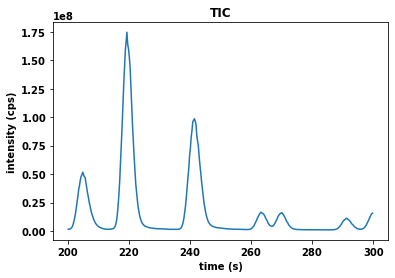

In [20]:
# Let's use matplotlib to visualize our TIC chromatogram
import matplotlib.pyplot as plt
from urllib.request import urlretrieve 

# retrieve MS data
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
output_ms_data = os.path.join(DATA_DIR, "ms_data.mzML")
urlretrieve (gh + "/src/data/FeatureFinderMetaboIdent_1_input.mzML", output_ms_data)

# load MS data into MSExperiment()
exp = MSExperiment()
MzMLFile().load(output_ms_data, exp)

# choose one of the following three methods to access the TIC data
# 1) recalculate TIC data with the calculateTIC() function
tic = exp.calculateTIC()
retention_times, intensities = tic.get_peaks()

# 2) get TIC data using list comprehensions
retention_times = [spec.getRT() for spec in exp]
intensities = [sum(spec.get_peaks()[1]) for spec in exp if spec.getMSLevel() == 1]

# 3) get TIC data looping over spectra in MSExperiment()
retention_times = []
intensities = []
for spec in exp:
    if spec.getMSLevel() == 1:
        retention_times.append(spec.getRT())
        intensities.append(sum(spec.get_peaks()[1]))

# plot retention times and intensities and add labels
plt.plot(retention_times, intensities)

plt.title('TIC')
plt.xlabel('time (s)')
plt.ylabel('intensity (cps)')

plt.show()

## Spectrum
`MSSpectrum` is the most important container for raw data and peaks. `MSSpectrum` is a container for 1D peak data (container for `Peak1D`). You can directly access these objects, however it is faster to use `get_peaks()` and `set_peaks` functions. These functions use numpy arrays for raw data access. Access spectrum metadata through `SpectrumSettings`.

In the example below, let's instantiate the `MSSpectrum` with peaks, sort the peaks according to m/z ratio, and finally let's display peak positions.

In [37]:
from pyopenms import MSSpectrum

spectrum = MSSpectrum()
mz = range(1500, 500, -100)
# i --> intensity
i = [0 for mass in mz]
spectrum.set_peaks([mz, i])

# Sort peak according to ascending m/z ratio
spectrum.sortByPosition()

# Iterate over spectrum of those peaks
# This process is expensive and should NOT be used in production code
# Direct access to the Peak1D object is expensive and should NOT be done
for p in spectrum:
    # p --> Peak1D object
    print(p.getMZ(), p.getIntensity())
    
# More efficient peak access can be achieved with get_peaks()
# Unpack tuple to allow 1-to-1 zipping
for mz, i in zip(*spectrum.get_peaks()):
    print(mz, i)
    
# Again, you can access a peak by its index
print(spectrum[2].getMZ(), spectrum[2].getIntensity())

600.0 0.0
700.0 0.0
800.0 0.0
900.0 0.0
1000.0 0.0
1100.0 0.0
1200.0 0.0
1300.0 0.0
1400.0 0.0
1500.0 0.0
600.0 0.0
700.0 0.0
800.0 0.0
900.0 0.0
1000.0 0.0
1100.0 0.0
1200.0 0.0
1300.0 0.0
1400.0 0.0
1500.0 0.0
800.0 0.0


In [44]:
from pyopenms import (MSExperiment, MSSpectrum, Precursor,
                      InstrumentSettings, FloatDataArray, StringDataArray,
                      IonSource)

# create spectrum and set properties
spectrum = MSSpectrum()
spectrum.setDriftTime(25) # 25 ms
spectrum.setRT(205.2) # 205.2 s
spectrum.setMSLevel(3) # MS3

# Add peak(s) to spectrum
spectrum.set_peaks( ([401.5], [900]) )

# create precursor information
p = Precursor()
p.setMZ(600) # isolation at 600 +/- 1.5 Th
p.setIsolationWindowLowerOffset(1.5)
p.setIsolationWindowUpperOffset(1.5)
p.setActivationEnergy(40) # 40 eV
p.setCharge(4) # 4+ ion

# and store precursor in spectrum
spectrum.setPrecursors([p])

# set additional instrument settings (e.g. scan polarity)
IS = InstrumentSettings()
IS.setPolarity(IonSource.Polarity.POSITIVE)
spectrum.setInstrumentSettings(IS)

# get and check scan polarity
polarity = spectrum.getInstrumentSettings().getPolarity()
if (polarity == IonSource.Polarity.POSITIVE):
    print("scan polarity: positive")
elif (polarity == IonSource.Polarity.NEGATIVE):
    print("scan polarity: negative")

# Optional: additional data arrays / peak annotations
fda = FloatDataArray()
fda.setName("Signal to Noise Array")
fda.push_back(15)
sda = StringDataArray()
sda.setName("Peak annotation")
sda.push_back("y15++")
spectrum.setFloatDataArrays( [fda] )
spectrum.setStringDataArrays( [sda] )

# Add spectrum to MSExperiment
exp = MSExperiment()
exp.addSpectrum(spectrum)

# Add second spectrum to the MSExperiment
spectrum2 = MSSpectrum()
spectrum2.set_peaks( ([1, 2], [1, 2]) )
exp.addSpectrum(spectrum2)

output_test_file = os.path.join(DATA_DIR, "testfile.mzML")
# store spectra in mzML file
MzMLFile().store(output_test_file, exp)

scan polarity: positive


## What just happened above?

- We created a single spectrum and set basic spectrum properties
    - drift time
    - RT
    - MS level
    - precursor charge
    - isolation window
    - activation energy
- We also set instrument settings (i.e. polarity of ion source)
- We then added actual peaks to the spectrum
    - 401.5 m/z with 900 intensity
- We then instantiated an MSExperiment object and saved our results to an .mzML file

We can view this .mzML file in TOPPView, an application that is installed with OpenMS.
We can also view our spectrum with matplotlib, as follows:

[(401.5, 900.0)]


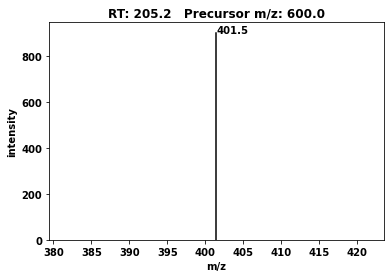

In [52]:
import matplotlib.pyplot as plt

def plot_spectrum(spectrum):
    # plot every peak in spectrum and annotate with it's m/z
    for mz, i in zip(*spectrum.get_peaks()):
        plt.plot([mz, mz], [0, i], color = 'black')
        plt.text(mz, i, str(mz))

    # for the title add RT and Precursor m/z if available
    title = ''
    if spectrum.getRT() >= 0:
        title += 'RT: ' + str(spectrum.getRT())
    if len(spectrum.getPrecursors()) >= 1:
        title += '   Precursor m/z: ' + str(spectrum.getPrecursors()[0].getMZ())

    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')
    plt.ylim(bottom=0)

    plt.show()

# plotting out spectrum that was defined earlier
plot_spectrum(spectrum)

## Chromatogram
We can use the MSChromatogram class, which is similar to the MSSpectrum class, but contains ChromatogramPeak and is derived from ChromatogramSettings

In [62]:
import numpy as np
from pyopenms import MSChromatogram, Product

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Create new chromatogram
chromatogram = MSChromatogram()

# Set raw data (RT and intensity)
rt = range(1500, 500, -100)
i = [gaussian(rtime, 100, 150) for rtime in rt]
chromatogram.set_peaks([rt, i])

# Sort peaks according to ascending retention time
chromatogram.sortByPosition()

# Iterate over chromatogram of those peaks
for p in chromatogram:
    print(p.getRT(), p.getIntensity())
    
# Here's a more efficient peak access using the get_peaks() method
for rt, i in zip(*chromatogram.get_peaks()):
    print(rt, i)
    
# Again, let's access a peak by its index
print(chromatogram[2].getRT(), chromatogram[2].getIntensity())

# Let's add metadata to our chromatogram
chromatogram.setNativeID("Trace XIC@405.2")

# Let's add a precursor ion for the chromatogram
p = Precursor()
p.setIsolationWindowLowerOffset(1.5)
p.setIsolationWindowUpperOffset(1.5)
p.setMZ(405.2)  # isolation at 405.2 +/- 1.5 Th
p.setActivationEnergy(40)  # 40 eV
p.setCharge(2)
p.setMetaValue("description", chromatogram.getNativeID())
p.setMetaValue("peptide_sequence", chromatogram.getNativeID())
chromatogram.setPrecursor(p)

# Also store a product ion for the chromatogram (e.g., for SRM)
p = Product()
p.setMZ(603.4)  # Transition from 405.2 --> 603.4
chromatogram.setProduct(p)

# Finally, instantiate a new experiment and store chromatogram as an mzML file
exp = MSExperiment()
exp.addChromatogram(chromatogram)
output_file_test3 = os.path.join(DATA_DIR, "testfile3.mzML")
MzMLFile().store(output_file_test3, exp)

600.0 0.003865920240059495
700.0 0.000335462624207139
800.0 1.866446837084368e-05
900.0 6.658361257905199e-07
1000.0 1.5229979055675358e-08
1100.0 2.2336314742243957e-10
1200.0 2.100409256244884e-12
1300.0 1.2664165777252073e-14
1400.0 4.895865324380882e-17
1500.0 1.2135636560129653e-19
600.0 0.0038659202
700.0 0.00033546262
800.0 1.8664468e-05
900.0 6.658361e-07
1000.0 1.5229979e-08
1100.0 2.2336315e-10
1200.0 2.1004093e-12
1300.0 1.2664166e-14
1400.0 4.8958653e-17
1500.0 1.2135637e-19
800.0 1.866446837084368e-05


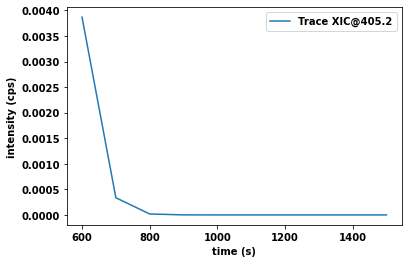

In [63]:
# Now let's visualize our exported file in matplotlib

import matplotlib.pyplot as plt

for chrom in exp.getChromatograms():
    retention_times, intensities = chrom.get_peaks()
    plt.plot(retention_times, intensities, label=chrom.getNativeID())
    
plt.xlabel('time (s)')
plt.ylabel('intensity (cps)')
plt.legend()
plt.show()

What we see above shows that the `MSExperiment` class can hold:
    
    - spectra
    - chromatograms